In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from scipy.sparse import hstack
import seaborn as sns
import matplotlib.pyplot as plt
from art.estimators.classification import XGBoostClassifier
from art.attacks.evasion import ZooAttack
import joblib


def load_and_preprocess_data():
    url_df = pd.read_csv('smaller_url_dataset_features.csv')
    domain_df = pd.read_csv('domain.csv')

    if len(url_df) != len(domain_df):
        raise ValueError("The number of rows does not match between the datasets.")

    url_df['similar_domain'] = domain_df['similar_domain'].values
    text_data = url_df['tokens']
    label_encoder = LabelEncoder()
    url_df['label'] = label_encoder.fit_transform(url_df['label'])
    label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print("Label mapping:", label_mapping)
    
    joblib.dump(label_encoder, 'label_encoder_iiii.joblib')

    return url_df, text_data, label_mapping

def extract_features(url_df, text_data):
    numerical_features = [
   'domain_length', 'url_kl_divergence', 'num_special_symbols','contains_ip',
         'path_kl_divergence', 'query_kl_divergence',
        'query_path_kl_divergence', 'presence_of_suspicious_file_extensions',
        'sub_domains_count', 'count_tlds', 'is_short_url', 'similar_domain'
    ]
    
    scaler = StandardScaler()
    other_features_scaled = scaler.fit_transform(url_df[numerical_features])
    
    # Save the StandardScaler
    joblib.dump(scaler, 'scaler_iiii.joblib')
    
    vectorizer = TfidfVectorizer(max_features=1000)  
    X_tfidf = vectorizer.fit_transform(text_data)


    X_combined = hstack((X_tfidf, other_features_scaled))

    return X_combined, url_df['label'], vectorizer, numerical_features


# Function to evaluate the model, modified to convert one-hot encoded predictions to class labels
def evaluate_model(model, X_test, y_test, is_art=False):
    y_pred = model.predict(X_test)
    if is_art:
        # Assuming y_pred is probabilities or one-hot, convert to class labels
        y_pred = np.argmax(y_pred, axis=1)
    
    # If y_test is also not in label format, convert it (use only if y_test is one-hot encoded)
    if y_test.ndim > 1:
        y_test = np.argmax(y_test, axis=1)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {fscore:.4f}")
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.show()

Loading and preprocessing data...
Label mapping: {'benign': 0, 'malware': 1, 'phishing': 2, 'spam': 3}
Splitting data into train and test sets...
Training the XGBoost model...
Evaluating the model on the original test set...
Accuracy: 0.9375, Precision: 0.9302, Recall: 0.8345, F1 Score: 0.8744


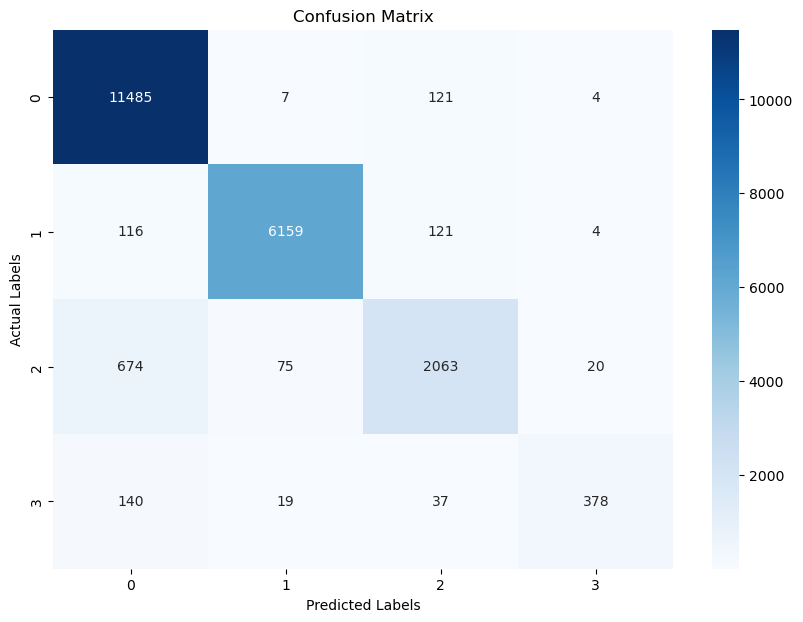

Wrapping the XGBoost model with ART's classifier...
Initializing the ZOO attack for adversarial example generation...
Generating adversarial examples for the test set...


ZOO:   0%|          | 0/21423 [00:00<?, ?it/s]

Evaluating the model on adversarial examples...
Accuracy on adversarial examples: 12.45%
Generating adversarial examples for the training set...


ZOO:   0%|          | 0/17139 [00:00<?, ?it/s]

Combining original and adversarial training sets for retraining...
Retraining the model with the combined dataset...
Evaluating the updated model on the original test set...
Accuracy: 0.9406, Precision: 0.9313, Recall: 0.8414, F1 Score: 0.8793


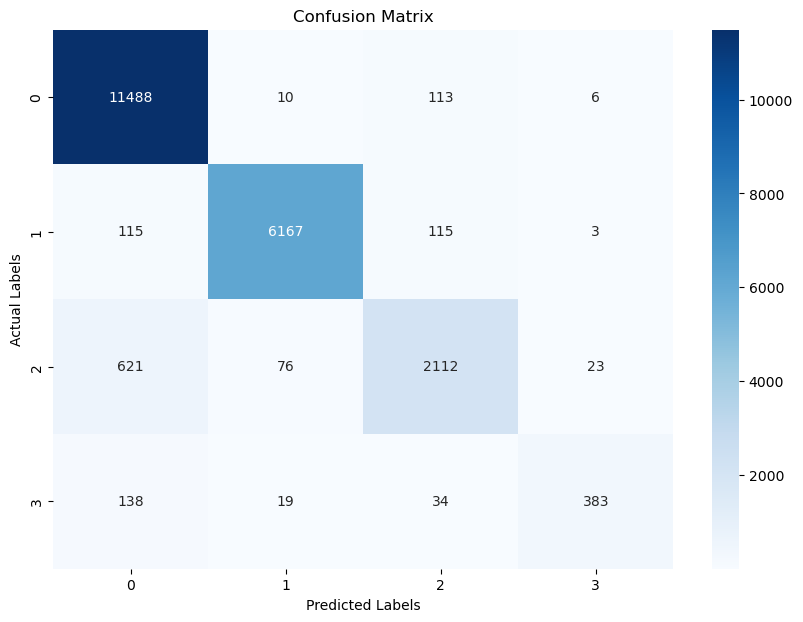

Evaluating the updated model on adversarial test examples...
Accuracy: 0.9405, Precision: 0.9313, Recall: 0.8413, F1 Score: 0.8793


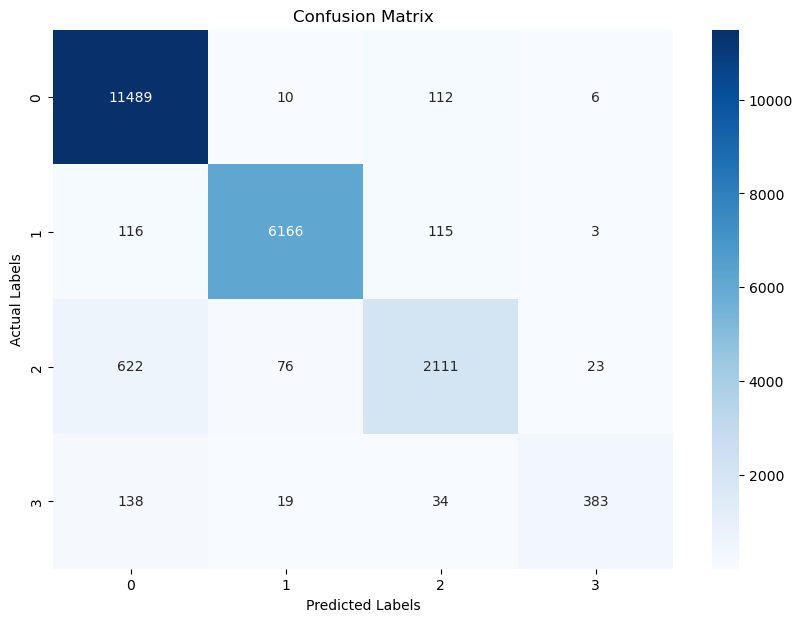

In [3]:
# Load and preprocess data
print("Loading and preprocessing data...")
url_df, text_data, label_mapping = load_and_preprocess_data()
X_combined, y, vectorizer, numerical_features = extract_features(url_df, text_data)

# Split the data
print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

_, X_minimize_train, _, y_minimize_train = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


# Train the XGBoost model
print("Training the XGBoost model...")
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_clf.fit(X_train, y_train)

# Evaluate the model
print("Evaluating the model on the original test set...")
evaluate_model(xgb_clf, X_test, y_test)

# Wrap the trained XGBoost model with ART's classifier
print("Wrapping the XGBoost model with ART's classifier...")
art_classifier = XGBoostClassifier(model=xgb_clf, nb_features=X_train.shape[1], nb_classes=len(np.unique(y_train)))

# Initialize the ZOO attack
print("Initializing the ZOO attack for adversarial example generation...")
zoo_attack = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=20,
                       binary_search_steps=10, initial_const=1e-3, abort_early=True, use_resize=False, 
                       use_importance=False, nb_parallel=1, batch_size=1, variable_h=0.2)

# Generate adversarial examples for the test set
print("Generating adversarial examples for the test set...")
X_test_adv = zoo_attack.generate(x=X_test.toarray())  # Ensure X_test is in the right format

# Predict and evaluate on adversarial examples
print("Evaluating the model on adversarial examples...")
y_pred_adv = art_classifier.predict(X_test_adv)
accuracy_adv = np.mean(np.argmax(y_pred_adv, axis=1) == y_test)
print(f"Accuracy on adversarial examples: {accuracy_adv * 100:.2f}%")

# Generate adversarial examples for the training set
print("Generating adversarial examples for the training set...")
X_train_adv = zoo_attack.generate(x=X_minimize_train.toarray())  # Ensure X_train is in the right format

# Combine original and adversarial training sets
print("Combining original and adversarial training sets for retraining...")
X_train_combined = np.vstack([X_train.toarray(), X_train_adv])
y_train_combined = np.hstack([y_train, y_minimize_train])

# Retrain the model with the combined dataset
print("Retraining the model with the combined dataset...")
art_classifier.fit(X_train_combined, y_train_combined)

# Evaluate the updated model on the original and adversarial test sets
print("Evaluating the updated model on the original test set...")
evaluate_model(art_classifier, X_test.toarray(), y_test, is_art=True)  # Convert to dense array if necessary

print("Evaluating the updated model on adversarial test examples...")
evaluate_model(art_classifier, X_test_adv, y_test, is_art=True)


In [4]:
joblib.dump(art_classifier, 'art_classifier_iiii.joblib')
joblib.dump(vectorizer, 'tfidf_vectorizer_iiii.joblib')

['tfidf_vectorizer_iiii.joblib']

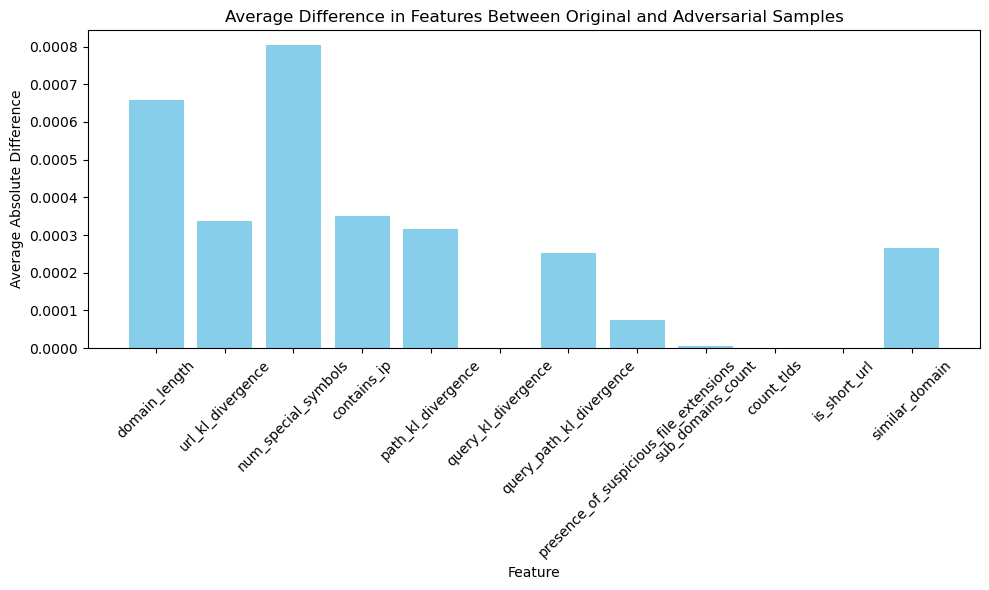

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a list of numerical feature names
numerical_features = [
   'domain_length', 'url_kl_divergence', 'num_special_symbols','contains_ip',
         'path_kl_divergence', 'query_kl_divergence',
        'query_path_kl_divergence', 'presence_of_suspicious_file_extensions',
        'sub_domains_count', 'count_tlds', 'is_short_url', 'similar_domain'
    ]

# Extract numerical features from original and adversarial datasets
# Note: Adjust indexing as per your actual data structure
# Here, it's assumed numerical features are at the end of the feature matrix
num_features_index = len(numerical_features)
X_test_num = X_test[:, -num_features_index:].toarray()  # Convert to dense if necessary
X_test_adv_num = X_test_adv[:, -num_features_index:]

# Calculate differences
differences = np.abs(X_test_adv_num - X_test_num).mean(axis=0)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(numerical_features, differences, color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Average Absolute Difference')
plt.title('Average Difference in Features Between Original and Adversarial Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




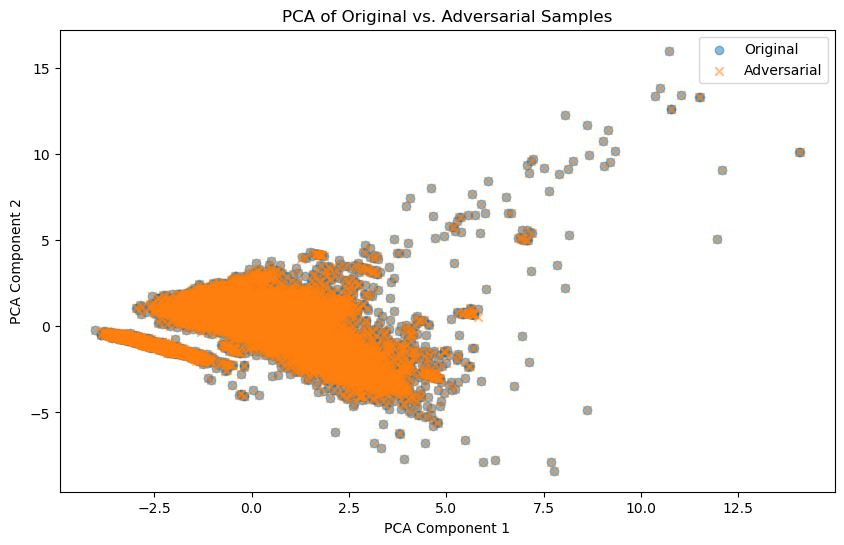

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_test and X_test_adv are provided and might be sparse
# Convert both matrices to dense if they are not already
X_test_dense = X_test.toarray() if not isinstance(X_test, np.ndarray) else X_test
X_test_adv_dense = X_test_adv.toarray() if not isinstance(X_test_adv, np.ndarray) else X_test_adv

# Assuming the extraction of numerical features is handled correctly elsewhere
# Concatenate original and adversarial samples for PCA
X_combined = np.vstack((X_test_dense, X_test_adv_dense))

# Apply PCA to reduce to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined)

# Correct slicing to split the transformed data back into original and adversarial samples
X_pca_original = X_pca[:X_test_dense.shape[0], :]
X_pca_adv = X_pca[X_test_dense.shape[0]:, :]

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_pca_original[:, 0], X_pca_original[:, 1], alpha=0.5, label='Original', marker='o')
plt.scatter(X_pca_adv[:, 0], X_pca_adv[:, 1], alpha=0.5, label='Adversarial', marker='x')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Original vs. Adversarial Samples')
plt.legend()
plt.show()


Detailed performance on adversarial examples:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     11617
           1       0.14      0.37      0.21      6400
           2       0.06      0.10      0.08      2832
           3       0.00      0.00      0.00       574

    accuracy                           0.12     21423
   macro avg       0.05      0.12      0.07     21423
weighted avg       0.05      0.12      0.07     21423



C:\Users\eilon\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\eilon\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\eilon\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


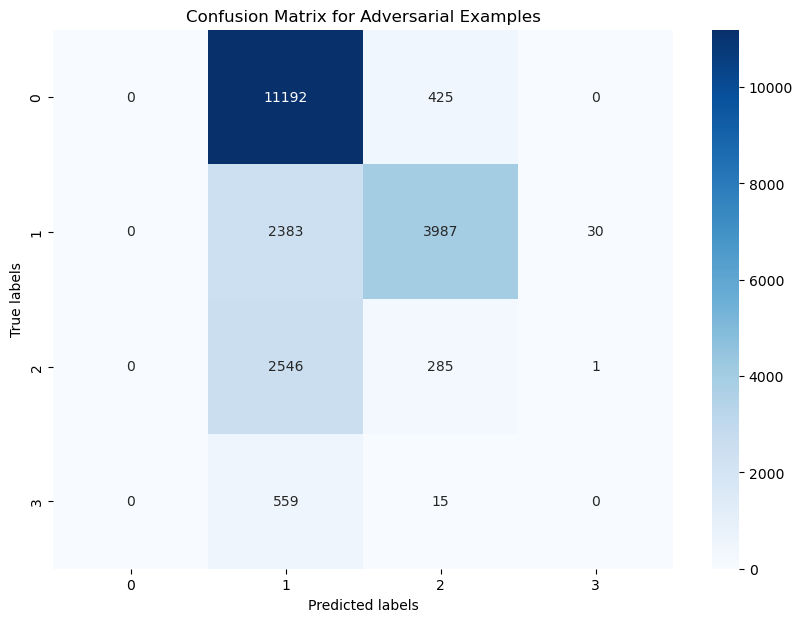

In [10]:
# Additional Imports
from sklearn.metrics import classification_report

# Assuming 'y_pred_adv' contains predictions on adversarial examples
print("Detailed performance on adversarial examples:")
print(classification_report(y_test, np.argmax(y_pred_adv, axis=1)))

# Plotting confusion matrix for adversarial examples
cm_adv = confusion_matrix(y_test, np.argmax(y_pred_adv, axis=1))
plt.figure(figsize=(10, 7))
sns.heatmap(cm_adv, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix for Adversarial Examples')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


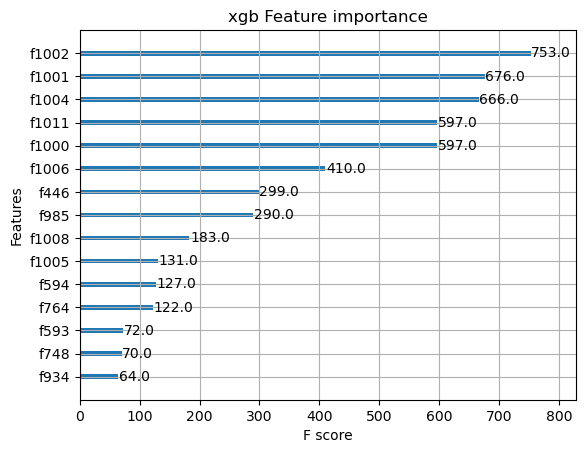

In [11]:
# Plot feature importance
xgb.plot_importance(xgb_clf, max_num_features=15)
plt.title('xgb Feature importance')
plt.show()


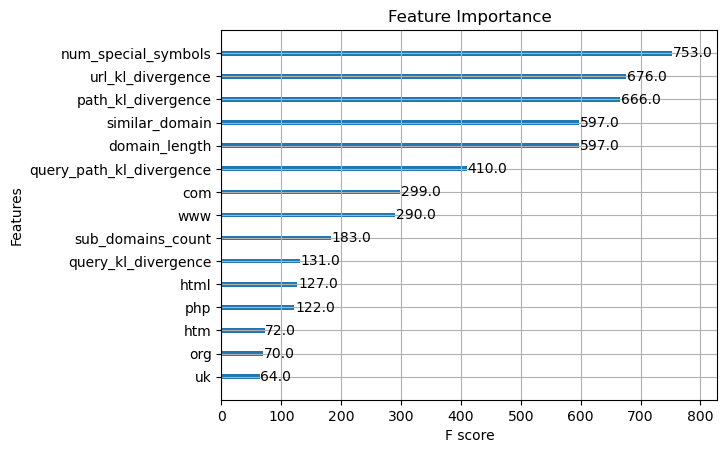

In [12]:
# Assuming vectorizer is a fitted TfidfVectorizer or CountVectorizer and numerical_features is a list of names
text_feature_names = vectorizer.get_feature_names_out()
all_feature_names = np.concatenate([text_feature_names, numerical_features])

# Set feature names on the model
xgb_clf.get_booster().feature_names = all_feature_names.tolist()

# Plot feature importance
xgb.plot_importance(xgb_clf, max_num_features=15, importance_type='weight', title='Feature Importance', xlabel='F score', ylabel='Features')
plt.show()
